In [1]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.linear_model import RidgeClassifier
from sktime.transformations.panel.rocket import Rocket
from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, matthews_corrcoef, cohen_kappa_score
from sklearn.model_selection import train_test_split


In [2]:
combined_df = pd.read_csv('C:/Users/DELL G7/Pictures/Camera Roll/projects/newdepression/combined_data.csv')

In [3]:
std_data = combined_df.copy()

In [4]:
# Standardize the 'activity' column
mean_activity = std_data['activity'].mean()
std_activity = std_data['activity'].std()
std_data['activity_standardized'] = (std_data['activity'] - mean_activity) / std_activity

std_data = std_data.drop('activity', axis=1)
std_data.head()

,timestamp,status,person,activity_standardized
0,2003-03-18 15:00:00,nondepressed,control_1,-0.332381
1,2003-03-18 15:01:00,nondepressed,control_1,-0.499176
2,2003-03-18 15:02:00,nondepressed,control_1,0.234721
3,2003-03-18 15:03:00,nondepressed,control_1,1.341127
4,2003-03-18 15:04:00,nondepressed,control_1,0.315339


# NEW TEST

In [5]:
# Step 1: Create a new dataframe where all the persons have an equal number of observations
min_obs = std_data['person'].value_counts().min()
equal_obs_data = std_data.groupby('person').apply(lambda x: x.sample(min_obs)).reset_index(drop=True)

# Step 2: Transform the status column into 1s and 0s
equal_obs_data['status'] = equal_obs_data['status'].replace({'depressed': 0, 'nondepressed': 1})

# Display the initial processed data
equal_obs_data.head()

,timestamp,status,person,activity_standardized
0,2003-05-23 13:37:00,0,condition_1,-0.499176
1,2003-05-17 10:10:00,0,condition_1,0.090166
2,2003-05-07 13:53:00,0,condition_1,0.849082
3,2003-05-21 07:08:00,0,condition_1,-0.499176
4,2003-05-23 10:26:00,0,condition_1,-0.499176


In [6]:
equal_obs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1061445 entries, 0 to 1061444
Data columns (total 4 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   timestamp              1061445 non-null  object 
 1   status                 1061445 non-null  int64  
 2   person                 1061445 non-null  object 
 3   activity_standardized  1061445 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 32.4+ MB


In [7]:
observations_per_person = equal_obs_data['person'].value_counts()
print(observations_per_person)


condition_1     19299
control_26      19299
control_16      19299
control_17      19299
control_18      19299
control_19      19299
control_2       19299
control_20      19299
control_21      19299
control_22      19299
control_23      19299
control_24      19299
control_25      19299
control_27      19299
control_14      19299
control_28      19299
control_29      19299
control_3       19299
control_30      19299
control_31      19299
control_32      19299
control_4       19299
control_5       19299
control_6       19299
control_7       19299
control_8       19299
control_15      19299
control_13      19299
condition_10    19299
condition_21    19299
condition_11    19299
condition_12    19299
condition_13    19299
condition_14    19299
condition_15    19299
condition_16    19299
condition_17    19299
condition_18    19299
condition_19    19299
condition_2     19299
condition_20    19299
condition_22    19299
control_12      19299
condition_23    19299
condition_3     19299
condition_

In [8]:
# Grouping by 'person' in equal_obs_data and aggregating the activity_standardized into a list
grouped_data_equal_obs = equal_obs_data.groupby('person')['activity_standardized'].apply(list).reset_index()

# Expanding the 'activity_standardized' series into columns
expanded_data_equal_obs = pd.DataFrame(grouped_data_equal_obs['activity_standardized'].tolist())

# Adding back the 'person' column and 'status' column
expanded_data_equal_obs['person'] = grouped_data_equal_obs['person']
expanded_data_equal_obs['status'] = equal_obs_data.groupby('person')['status'].first().values

expanded_data_equal_obs


,0,1,2,3,4,5,6,7,8,9,...,19291,19292,19293,19294,19295,19296,19297,19298,person,status
0,-0.499176,0.090166,0.849082,-0.499176,-0.499176,0.982518,-0.499176,-0.499176,0.573871,-0.499176,...,0.890781,0.131865,-0.499176,-0.490836,-0.499176,-0.499176,-0.418558,0.245841,condition_1,0
1,0.932480,1.888770,-0.293462,0.801824,1.235491,-0.499176,-0.343501,-0.499176,1.741435,1.471783,...,1.026997,-0.499176,1.471783,0.888001,0.501593,0.568311,2.675486,-0.446358,condition_10,0
2,-0.457477,0.142984,-0.499176,-0.499176,-0.449138,0.671168,-0.499176,-0.499176,-0.499176,-0.499176,...,1.588540,-0.051610,0.190243,-0.490836,-0.499176,-0.340721,-0.499176,-0.499176,condition_11,0
3,-0.499176,0.131865,-0.335161,0.437655,-0.201725,1.671937,-0.499176,-0.499176,-0.499176,-0.499176,...,-0.499176,-0.499176,-0.499176,-0.499176,2.675486,-0.499176,-0.499176,-0.499176,condition_12,0
4,-0.443578,-0.438018,1.216031,0.373717,-0.499176,1.010317,0.707307,-0.499176,0.668388,-0.499176,...,-0.499176,-0.349061,-0.499176,-0.499176,-0.499176,-0.343501,2.350236,-0.248984,condition_13,0
5,-0.499176,0.109625,-0.499176,-0.376860,-0.499176,-0.499176,0.109625,-0.215625,-0.499176,-0.499176,...,-0.499176,-0.499176,0.804604,-0.499176,-0.499176,-0.499176,-0.499176,-0.499176,condition_14,0
6,-0.499176,-0.499176,1.646918,-0.499176,2.013867,-0.499176,0.401516,-0.449138,-0.499176,-0.499176,...,-0.499176,-0.499176,-0.499176,-0.004351,-0.471377,-0.482496,-0.499176,-0.499176,condition_15,0
7,1.355027,0.154104,-0.499176,-0.346281,-0.499176,-0.499176,-0.490836,-0.499176,1.677497,-0.499176,...,-0.465817,-0.490836,-0.499176,-0.499176,-0.499176,-0.499176,-0.499176,4.449071,condition_16,0
8,-0.499176,-0.176706,-0.499176,1.168773,-0.424118,-0.499176,-0.490836,0.095726,-0.499176,-0.499176,...,-0.499176,-0.374080,-0.429678,-0.499176,-0.499176,-0.079409,-0.499176,-0.499176,condition_17,0
9,-0.176706,-0.499176,-0.499176,-0.499176,-0.426898,-0.499176,-0.465817,-0.499176,-0.499176,-0.499176,...,-0.248984,-0.463037,-0.257323,-0.499176,-0.499176,-0.499176,-0.499176,-0.465817,condition_18,0


In [9]:
# Reordering the columns so that 'person' and 'status' are the first columns
cols_equal_obs = expanded_data_equal_obs.columns.tolist()
cols_equal_obs = cols_equal_obs[-2:] + cols_equal_obs[:-2]
expanded_data_equal_obs = expanded_data_equal_obs[cols_equal_obs]
expanded_data_equal_obs

,person,status,0,1,2,3,4,5,6,7,...,19289,19290,19291,19292,19293,19294,19295,19296,19297,19298
0,condition_1,0,-0.499176,0.090166,0.849082,-0.499176,-0.499176,0.982518,-0.499176,-0.499176,...,-0.237864,-0.499176,0.890781,0.131865,-0.499176,-0.490836,-0.499176,-0.499176,-0.418558,0.245841
1,condition_10,0,0.932480,1.888770,-0.293462,0.801824,1.235491,-0.499176,-0.343501,-0.499176,...,-0.499176,-0.418558,1.026997,-0.499176,1.471783,0.888001,0.501593,0.568311,2.675486,-0.446358
2,condition_11,0,-0.457477,0.142984,-0.499176,-0.499176,-0.449138,0.671168,-0.499176,-0.499176,...,-0.479717,-0.499176,1.588540,-0.051610,0.190243,-0.490836,-0.499176,-0.340721,-0.499176,-0.499176
3,condition_12,0,-0.499176,0.131865,-0.335161,0.437655,-0.201725,1.671937,-0.499176,-0.499176,...,-0.054390,-0.101648,-0.499176,-0.499176,-0.499176,-0.499176,2.675486,-0.499176,-0.499176,-0.499176
4,condition_13,0,-0.443578,-0.438018,1.216031,0.373717,-0.499176,1.010317,0.707307,-0.499176,...,0.526612,-0.490836,-0.499176,-0.349061,-0.499176,-0.499176,-0.499176,-0.343501,2.350236,-0.248984
5,condition_14,0,-0.499176,0.109625,-0.499176,-0.376860,-0.499176,-0.499176,0.109625,-0.215625,...,0.323679,1.185452,-0.499176,-0.499176,0.804604,-0.499176,-0.499176,-0.499176,-0.499176,-0.499176
6,condition_15,0,-0.499176,-0.499176,1.646918,-0.499176,2.013867,-0.499176,0.401516,-0.449138,...,-0.499176,-0.499176,-0.499176,-0.499176,-0.499176,-0.004351,-0.471377,-0.482496,-0.499176,-0.499176
7,condition_16,0,1.355027,0.154104,-0.499176,-0.346281,-0.499176,-0.499176,-0.490836,-0.499176,...,1.610779,-0.485276,-0.465817,-0.490836,-0.499176,-0.499176,-0.499176,-0.499176,-0.499176,4.449071
8,condition_17,0,-0.499176,-0.176706,-0.499176,1.168773,-0.424118,-0.499176,-0.490836,0.095726,...,-0.499176,-0.499176,-0.499176,-0.374080,-0.429678,-0.499176,-0.499176,-0.079409,-0.499176,-0.499176
9,condition_18,0,-0.176706,-0.499176,-0.499176,-0.499176,-0.426898,-0.499176,-0.465817,-0.499176,...,-0.212845,0.176343,-0.248984,-0.463037,-0.257323,-0.499176,-0.499176,-0.499176,-0.499176,-0.465817


In [10]:
# Drop a column
column_to_drop = 'person'
expanded_data_equal_obs = expanded_data_equal_obs.drop(column_to_drop, axis=1)

In [11]:
# Splitting the data in expanded_data_equal_obs into training and test sets
train_data, test_data = train_test_split(expanded_data_equal_obs, test_size=0.20, stratify=expanded_data_equal_obs['status'], random_state=42)

# Checking the distribution of 'status' in both train and test data
train_distribution = train_data['status'].value_counts(normalize=True)
test_distribution = test_data['status'].value_counts(normalize=True)

train_distribution, test_distribution


(1    0.590909
 0    0.409091
 Name: status, dtype: float64,
 1    0.545455
 0    0.454545
 Name: status, dtype: float64)

In [12]:
train_data

,status,0,1,2,3,4,5,6,7,8,...,19289,19290,19291,19292,19293,19294,19295,19296,19297,19298
26,1,-0.488056,0.787924,-0.499176,-0.104428,-0.154467,1.271629,-0.493616,-0.499176,-0.499176,...,-0.493616,-0.493616,-0.499176,-0.493616,-0.499176,1.163213,-0.499176,-0.499176,-0.493616,-0.499176
41,1,-0.499176,2.286298,-0.176706,-0.499176,-0.421338,-0.499176,0.095726,0.876882,-0.499176,...,1.224371,2.466993,-0.499176,-0.499176,0.212482,-0.499176,-0.499176,-0.499176,-0.499176,0.040127
0,0,-0.499176,0.090166,0.849082,-0.499176,-0.499176,0.982518,-0.499176,-0.499176,0.573871,...,-0.237864,-0.499176,0.890781,0.131865,-0.499176,-0.490836,-0.499176,-0.499176,-0.418558,0.245841
28,1,-0.012691,4.899418,2.870080,-0.499176,-0.485276,5.424821,-0.287902,-0.499176,-0.499176,...,0.671168,-0.499176,1.955488,-0.485276,-0.499176,2.466993,2.975717,-0.499176,-0.499176,-0.499176
35,1,-0.499176,-0.499176,-0.490836,-0.021031,1.079815,-0.499176,-0.112768,-0.499176,-0.499176,...,0.643369,-0.499176,-0.490836,-0.254544,0.109625,-0.490836,-0.499176,-0.037710,-0.490836,4.604747
45,1,-0.499176,-0.499176,-0.499176,-0.499176,-0.499176,-0.499176,-0.499176,-0.499176,-0.499176,...,-0.499176,-0.499176,-0.499176,-0.254544,-0.418558,-0.499176,-0.499176,-0.499176,-0.499176,-0.499176
42,1,-0.499176,1.822052,-0.101648,-0.499176,-0.499176,1.296649,0.849082,1.480123,-0.499176,...,-0.112768,0.412636,-0.329601,-0.499176,-0.499176,-0.499176,-0.499176,-0.499176,1.897110,-0.396319
39,1,-0.499176,-0.499176,-0.499176,-0.499176,-0.126667,0.643369,4.932777,0.849082,-0.393539,...,1.749775,-0.499176,-0.499176,0.295880,1.241050,0.471014,1.480123,3.348225,2.492012,0.351478
11,0,-0.474157,1.410625,-0.488056,-0.488056,3.214790,-0.474157,-0.474157,-0.479717,-0.479717,...,0.409856,-0.471377,-0.479717,-0.054390,0.029008,-0.488056,1.538501,-0.474157,0.170783,-0.176706
15,0,0.559971,1.015877,-0.368520,-0.499176,-0.499176,-0.499176,-0.499176,0.095726,-0.499176,...,-0.499176,-0.415779,-0.499176,1.658038,-0.499176,-0.499176,-0.499176,1.068696,-0.499176,-0.499176


In [13]:
test_data

,status,0,1,2,3,4,5,6,7,8,...,19289,19290,19291,19292,19293,19294,19295,19296,19297,19298
6,0,-0.499176,-0.499176,1.646918,-0.499176,2.013867,-0.499176,0.401516,-0.449138,-0.499176,...,-0.499176,-0.499176,-0.499176,-0.499176,-0.499176,-0.004351,-0.471377,-0.482496,-0.499176,-0.499176
19,0,0.434875,-0.201725,1.293869,0.885221,-0.499176,-0.471377,-0.490836,-0.438018,-0.201725,...,-0.499176,0.932480,-0.499176,0.534952,0.754565,0.290320,-0.499176,0.404296,-0.485276,-0.499176
10,0,-0.474157,-0.176706,1.477343,-0.499176,-0.499176,-0.499176,-0.287902,-0.499176,-0.490836,...,-0.499176,-0.499176,2.136183,-0.499176,-0.499176,-0.499176,-0.499176,-0.499176,-0.499176,-0.229524
47,1,2.483672,-0.499176,-0.499176,-0.499176,-0.499176,-0.346281,-0.499176,2.778343,-0.499176,...,1.249390,-0.499176,-0.499176,-0.499176,-0.499176,-0.499176,-0.499176,0.451555,-0.499176,-0.499176
54,1,-0.287902,-0.490836,-0.499176,-0.479717,-0.479717,-0.479717,-0.454697,-0.479717,-0.485276,...,-0.499176,-0.479717,-0.485276,1.077035,0.006768,-0.287902,-0.440798,-0.499176,-0.490836,-0.490836
48,1,-0.499176,-0.499176,2.931238,-0.499176,2.433634,-0.499176,-0.499176,-0.460257,-0.499176,...,-0.499176,0.268080,-0.499176,1.013097,-0.499176,-0.499176,3.387144,-0.499176,-0.499176,-0.499176
44,1,0.195803,-0.465817,-0.499176,3.003516,-0.376860,-0.476937,1.355027,-0.499176,-0.287902,...,0.643369,0.131865,-0.482496,-0.404659,-0.176706,-0.476937,-0.137787,-0.490836,0.440435,1.974948
34,1,-0.387979,0.259741,1.118734,-0.499176,0.315339,3.968146,1.341127,-0.499176,0.632249,...,2.116723,1.168773,0.040127,-0.304582,2.661587,0.462674,0.429315,-0.499176,-0.499176,1.118734
51,1,-0.490836,-0.485276,-0.499176,-0.485276,-0.499176,0.932480,-0.485276,-0.490836,-0.490836,...,-0.490836,-0.499176,-0.499176,-0.490836,-0.479717,-0.485276,0.101286,-0.490836,-0.490836,-0.485276
7,0,1.355027,0.154104,-0.499176,-0.346281,-0.499176,-0.499176,-0.490836,-0.499176,1.677497,...,1.610779,-0.485276,-0.465817,-0.490836,-0.499176,-0.499176,-0.499176,-0.499176,-0.499176,4.449071


In [14]:
# Applying the provided code to the train_data and test_data dataframes
y_train = train_data.status.to_numpy('<U1')
y_test = test_data.status.to_numpy('<U1')
X_train = train_data.drop('status', axis=1)
X_test = test_data.drop('status', axis=1)


In [15]:
from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Convert to nested dataframe format
X_train_nested = from_2d_array_to_nested(X_train)
X_test_nested = from_2d_array_to_nested(X_test)


In [16]:


# Fit the Rocket model on this nested dataframe
rocket = Rocket(num_kernels=10000, random_state=111)
rocket.fit(X_train_nested)

# Transform the data
X_train_transform = rocket.transform(X_train_nested)

X_train_transform.shape

(44, 20000)

RIDGE CLASSIFIER

In [17]:
import numpy as np
from sklearn.linear_model import RidgeClassifierCV

#import classifier
classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
classifier.fit(X_train_transform, y_train)

RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]))

In [18]:

X_test_transform = rocket.transform(X_test_nested)
classifier.score(X_test_transform, y_test)

0.45454545454545453

In [19]:
X_test_transform.shape

(11, 20000)

In [20]:
y_pred_test = classifier.predict(X_test_transform)
y_pred_train = classifier.predict(X_train_transform)

In [21]:
# nondepressed = 1, deppressed =0
# Accuracy

from sklearn.metrics import accuracy_score

test_accuracy = accuracy_score(y_test, y_pred_test)
print(f" Test Accuracy: {test_accuracy:.4f}")

train_accuracy = accuracy_score(y_train, y_pred_train)
print(f" Train Accuracy: {train_accuracy:.4f}")



 Test Accuracy: 0.4545
 Train Accuracy: 1.0000


In [22]:
# Classification Report
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.33      0.20      0.25         5
           1       0.50      0.67      0.57         6

    accuracy                           0.45        11
   macro avg       0.42      0.43      0.41        11
weighted avg       0.42      0.45      0.43        11



In [23]:
# Classification Report
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        26

    accuracy                           1.00        44
   macro avg       1.00      1.00      1.00        44
weighted avg       1.00      1.00      1.00        44



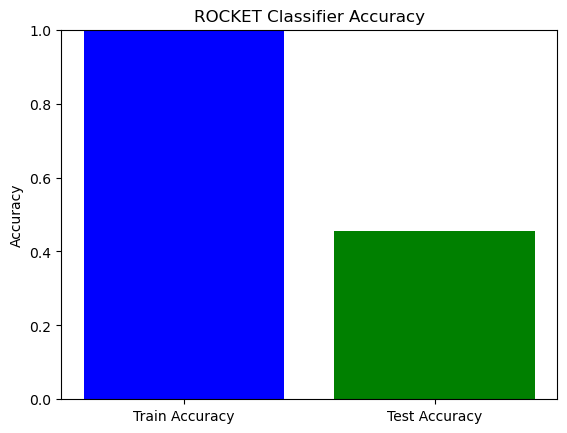

In [24]:
import matplotlib.pyplot as plt

labels = ['Train Accuracy', 'Test Accuracy']
accuracies = [train_accuracy, test_accuracy]

plt.bar(labels, accuracies, color=['blue', 'green'])
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.title('ROCKET Classifier Accuracy')
plt.show()


In [25]:

# 1. Visualize the confusion matrix with actual labels
labels = ['depressed', 'nondepressed']
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


NameError: name 'y_pred' is not defined

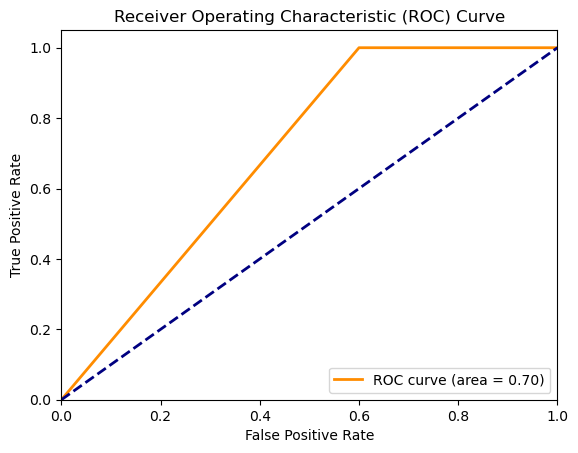

In [42]:
#  2. Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test.astype(int), y_pred.astype(int))
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [43]:
# 3. Compute Cohen Kappa Score
kappa = cohen_kappa_score(y_test, y_pred)
print(f"Cohen Kappa Score: {kappa:.4f}")

# 4. Compute MCC Score
mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

Cohen Kappa Score: 0.4211
Matthews Correlation Coefficient (MCC): 0.5164


LOGISTIC REGRESSION

In [44]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(max_iter=10000)
classifier.fit(X_train_transform, y_train)

LogisticRegression(max_iter=10000)

In [45]:
classifier.score(X_test_transform, y_test)

0.7272727272727273

In [46]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(X_train_transform, y_train)
classifier.score(X_test_transform, y_test)

0.45454545454545453

In [48]:
import lightgbm as lgb
classifier = lgb.LGBMClassifier()
classifier.fit(X_train_transform, y_train)
classifier.score(X_test_transform, y_test)

[LightGBM] [Info] Number of positive: 26, number of negative: 18
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.792415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 319296
[LightGBM] [Info] Number of data points in the train set: 44, number of used features: 20000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.590909 -> initscore=0.367725
[LightGBM] [Info] Start training from score 0.367725
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

0.5454545454545454

In [49]:
from sklearn.svm import SVC
classifier = SVC(kernel='linear')
classifier.fit(X_train_transform, y_train)
classifier.score(X_test_transform, y_test)

0.7272727272727273